# Sparkify: Capstone Project
## Table of Contents
* [Introduction](#intro)
* [Load and Clean the dataset](#data)
* [Exploratory Data Analysis](#EDA)
    * [Users who stayed vs users who churned](#EDA1)
    * [Time Period: Users who churned vs users who stayed](#EDA2)
    * [Gender: Users who churned vs users who stayed](#EDA3)
    * [Level: Users who stayed vs users who churned](#EDA4)
    * [Songs Per Session: Users who churned vs users who stayed](#EDA5)
    * [Number of different artists listened to](#EDA6)
    * [Days since registration for Sparkify](#EDA7)
* [Feature Engineering](#features)
    * [Gender](#FE1)
    * [Level](#FE2)
    * [Number of songs per session](#FE3)
    * [Number of thumb down](#FE4)
    * [Number of thumb up](#FE5)
    * [Number of songs added to playlist](#FE6)
    * [Number of different artists listened to](#FE7)
    * [Number of days since registration on the app](#FE8)
    * [Label](#FE9)
* [Modeling](#modeling)
* [Conclusion](#conclusion)
* [Improvements](#improvements)
* [References](#reference)
 
<a id='intro'></a>
# Introduction
In this project I have used a music app dataset called Sparkify to engineer relevant features for predicting churn (process of cancelling services). By identifying the customers before they churn, Sparkify can offer them discounts to stay thereby saving revenue.  
This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

In [1]:
# import libraries

import pandas as pd
import numpy as np
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import time

In [2]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1639929645534'),
 ('spark.driver.port', '44117'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '8fdbe0906e70'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

<a id='data'></a>
# Load and Clean Dataset
The mini-dataset file is `mini_sparkify_event_data.json`. We will now load and clean the dataset, checking for invalid or missing data. 

In [4]:
# load the dataset

df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
# print the schema

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
# check number of rows

df.count() 

286500

## Dealing with missing data

In [8]:
# drop rows with missing userId or sessionId

df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [9]:
# check number of rows left

df.count()

286500

Number of rows is still the same.<br>
Now, we will check for duplicate values.

In [10]:
# drop duplicate userIds

df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [11]:
# drop duplicate sessionIds

df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



There are entries with an empty string for the userId. We will remove them now.

In [12]:
# remove those with an empty string userId

df = df.filter(df["userId"] != "")

In [13]:
# check number of rows

df.count()

278154

In [14]:
# convert to pandas

df_pd = df.toPandas()
df_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


#### We will identify the users who have churned using the Cancellation Confirmation event under the page column.

In [15]:
# check Cancellation Confirmation page

df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



From the above we can see that Cancellation Confirmation is the page that a user is taken to once they have confirmed that they would like to cancel their service. This is how we are identifying churn.

In [16]:
# number of users who churned

df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

In [17]:
# userIds that churned

df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



We will now create the flag for churned users who will be assigned a 1 if churned and a 0 where they have not churned.<br> We will add this flag to the dataset as a column named "churn".

In [18]:
# flag the records where Cancellation Confirmation page is reached - 1 if it is and 0 if not

churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [19]:
#creating churn column

df = df.withColumn("churn", churn_event("page"))

In [20]:
# check the column

df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [21]:
# sort records for a user in reverse time order to add up values in churn column

windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [22]:
# create column churn which contains sum of churn 1s over records

df = df.withColumn("churn", Fsum("churn").over(windowval))

In [23]:
# groupby churn to get number of rows

df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

In [24]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



<a id='EDA1'></a>
## Users who stayed vs users who churned

In [25]:
# convert to pandas 

df_churn = df_churn.toPandas()

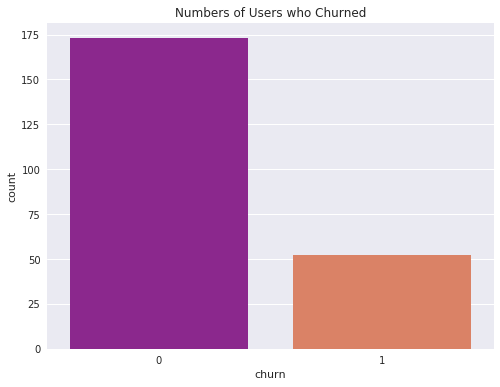

In [26]:
# plot the number of users who churned

plt.figure(figsize = [8,6])
sns.barplot(data = df_churn, x = 'churn', y='count', palette='plasma')
plt.title("Numbers of Users who Churned");

In [27]:
# churn rate = [(users churned)/(total users)]*100

print('Churn rate:', 52/(173+52) * 100)

Churn rate: 23.11111111111111


173 users stayed while 52 users churned. This means that 23% of users churned. 

<a id='EDA2'></a>
## Time Period: Users who churned vs users who stayed

In [28]:
# customers who churned

df_churned_len = df.filter(df.churn ==1)

In [29]:
# convert to pandas

df_churned_len_pd = df_churned_len.toPandas()

In [30]:
# drop the null values

df_churned_len_pd.length.dropna(inplace=True)

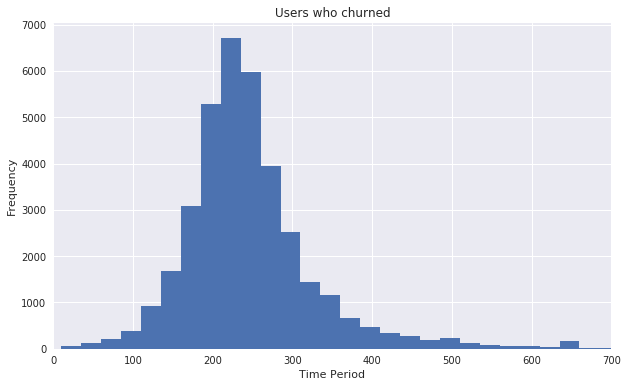

In [31]:
# plot the histogram

plt.figure(figsize = [10,6])
bin_edges = np.arange (10, df_churned_len_pd['length'].max()+25, 25)
plt.hist(data = df_churned_len_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Time Period')
plt.ylabel('Frequency')
plt.title("Users who churned");

In [32]:
# users who stayed

df_stayed_len = df.filter(df.churn ==0)

In [33]:
# convert to pandas

df_stayed_len_pd = df_stayed_len.toPandas()

In [34]:
# drop null values

df_stayed_len_pd.length.dropna(inplace=True)

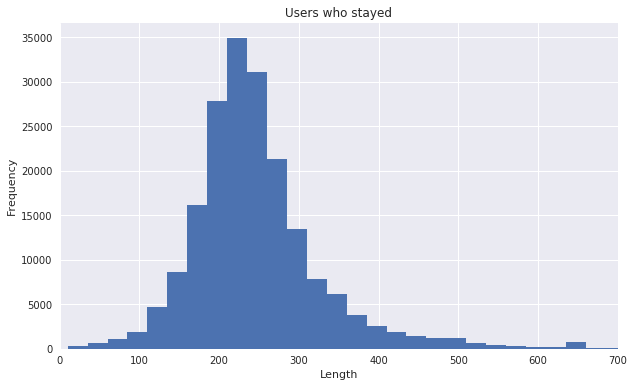

In [35]:
# plot histogram

plt.figure(figsize = [10,6])
bin_edges = np.arange (10, df_stayed_len_pd['length'].max()+25, 25)
plt.hist(data = df_stayed_len_pd, x = 'length', bins = bin_edges)
plt.xlim(0,700)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title("Users who stayed");

We can see from the above plots that length distribution is very similar for users that churned and those who stayed. This won't be very useful for predicting customer churn. 

<a id='EDA3'></a>
## Gender - Users who churned vs users who stayed

In [36]:
# create gender df grouped by churn and gender

df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

In [37]:
# show gender df

df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [38]:
# convert to pandas

df_gender = df_gender.toPandas()

In [39]:
# order for the visualisation

df_gender = df_gender.sort_values('count', ascending = False)

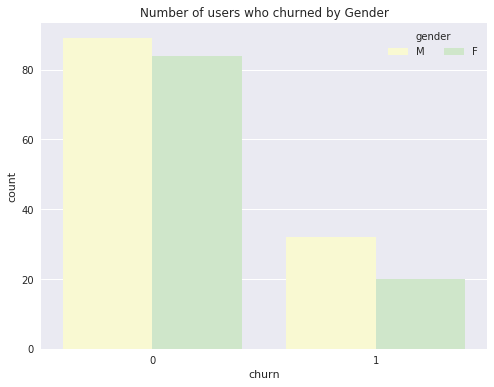

In [40]:
# plot bar chart

plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_gender, x = 'churn', y='count', hue = 'gender', palette='Pastel1_r')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'gender')
plt.title("Number of users who churned by Gender");

In [41]:
# male churn rate

print('Male churn rate:', 32/(89+32))

Male churn rate: 0.2644628099173554


In [42]:
# female churn rate

print('Female churn rate:', 20/(20+84))

Female churn rate: 0.19230769230769232


We can see that more male users churned(rate of 0.264) compared to female users (rate of 0.192).

<a id='EDA4'></a>
## Level: Users who stayed vs users who churned
Level here means if the user paid for the app or if they used it for free with ads.

In [43]:
# create the level dataframe

df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()

In [44]:
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [45]:
# convert to pandas

df_level = df_level.toPandas()

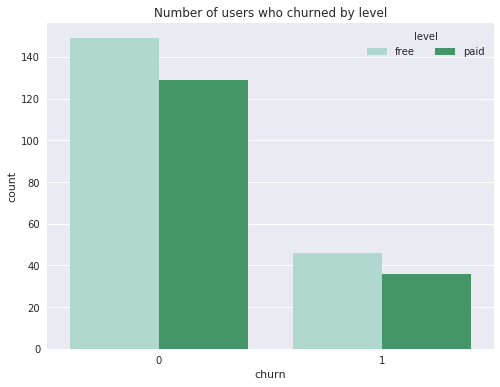

In [46]:
# plot the bar chart

plt.figure(figsize = [8,6])
ax = sns.barplot(data = df_level, x = 'churn', y='count', hue = 'level', palette='BuGn')
ax.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')
plt.title("Number of users who churned by level");

In [47]:
# free churn rate

print('Free churn rate:', 46/(46+149))

Free churn rate: 0.2358974358974359


In [48]:
# paid churn rate

print('Paid churn rate:', 36/(129+36))

Paid churn rate: 0.21818181818181817


Users who used the service for free were slightly more likely to churn (rate of 0.236) compared to those who paid for the app (0.218).

<a id='EDA5'></a>
## Songs Per Session: Users who churned vs users who stayed

In [49]:
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()

In [50]:
df_songs.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



In [51]:
df_songs = df_songs.groupby('churn').agg({"count":"avg"})

In [52]:
# convert to pandas

df_songs = df_songs.toPandas()

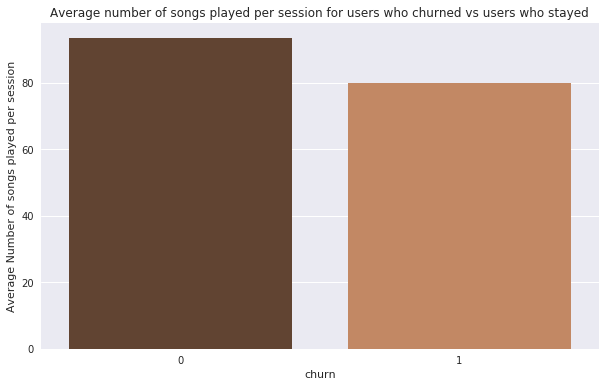

In [53]:
# plot bar chart

plt.figure(figsize = [10,6])
ax = sns.barplot(data = df_songs, x = 'churn', y='avg(count)', palette='copper')
plt.title("Average number of songs played per session for users who churned vs users who stayed")
plt.ylabel("Average Number of songs played per session");

From the chart we can see that those who churned from Sparkify were listening to fewer songs on average per session.

<a id='EDA6'></a>
## Number of different artists listened to

In [54]:
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [55]:
df_artists.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



In [56]:
# convert to pandas

df_artists = df_artists.toPandas()

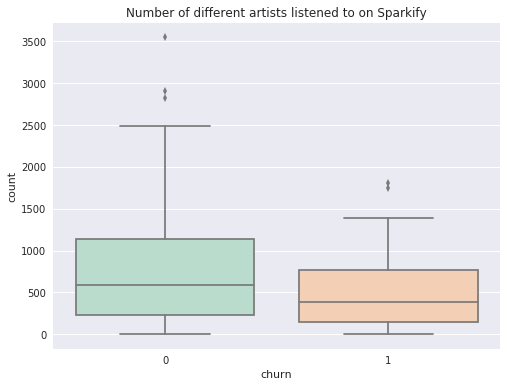

In [57]:
# plot boxplot

plt.figure(figsize = [8,6])
ax = sns.boxplot(data = df_artists, x = 'churn', y='count', palette='Pastel2')
plt.title("Number of different artists listened to on Sparkify");

<a id='EDA7'></a>
## Days since registration for Sparkify
#### (number of days since a user had registered)

In [58]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [59]:
# order by last timestamp

w = Window.partitionBy("userId").orderBy(desc("ts"))

In [60]:
# create a rank with the most recent timestamp as rank number 1

df_days = df_days.withColumn("Rank", dense_rank().over(w))

In [61]:
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [62]:
# get those with a rank of 1 

df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

In [63]:
# minus the registration from ts 

df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

In [64]:
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))

In [65]:
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [66]:
# convert to pandas

df_days_pd = df_days.toPandas()

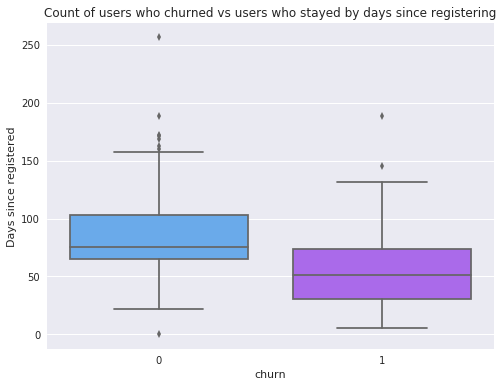

In [67]:
# plot boxplot

plt.figure(figsize=[8,6])
sns.boxplot(data = df_days_pd, x = 'churn', y ='days', palette='cool')
plt.title('Count of users who churned vs users who stayed by days since registering')
plt.ylabel("Days since registered");

<a id='features'></a>
# Feature Engineering
The features we will add:

* Categorical:
    1. gender
    2. level
* Numerical:
    1. number of songs per session
    2. number of thumb down actions
    3. number of thumbs up actions
    4. number of songs added to playlist
    5. number of different artists listened to on Sparkify
    6. number of days since registering

<a id='FE1'></a>
## Gender

In [68]:
feat1_gender = df.select(['userId', 'gender']).dropDuplicates()

In [69]:
# create gender column 
# assign 1 for 'female' and 0 for 'male'

feat1_gender = feat1_gender.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [70]:
feat1_gender.count()

225

In [71]:
feat1_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



<a id='FE2'></a>
## Level

In [72]:
df1 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
df1 = df1.withColumn("Rank", dense_rank().over(w))

In [73]:
df1.show(5)

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
+------+-----+-------------+----+
only showing top 5 rows



In [74]:
feat2_level = df1.filter(df1.Rank == 1).drop(df1.Rank)
feat2_level = feat2_level.drop('ts')
feat2_level = feat2_level.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))
feat2_level.count()

225

In [75]:
feat2_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



<a id='FE3'></a>
## Average Number of songs per session

In [76]:
feat3_song = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()

In [77]:
df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows



In [78]:
feat3_song = feat3_song.groupby('userId').agg({"count":"avg"})
feat3_song = feat3_song.withColumnRenamed("avg(count)", "avg_song")

In [79]:
feat3_song.count()

225

In [80]:
feat3_song.show(2)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



<a id='FE4'></a>
## Number of thumb down actions

In [81]:
feat4_thumbdown = df.select(["userId", "page"])
thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
feat4_thumbdown = feat4_thumbdown.withColumn("Thumbs Down", thumddown_event("page"))
feat4_thumbdown = feat4_thumbdown.groupby('userId').sum("Thumbs Down")
feat4_thumbdown = feat4_thumbdown.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [82]:
feat4_thumbdown.count()

225

In [83]:
feat4_thumbdown.show(2)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|100010|          5|
|200002|          6|
+------+-----------+
only showing top 2 rows



<a id='FE5'></a>
## Number of thumbs up actions

In [84]:
feat5_thumbup = df.select(["userId", "page"])
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
feat5_thumbup = feat5_thumbup.withColumn("Thumbs Up", thumbup_event("page"))
feat5_thumbup = feat5_thumbup.groupby('userId').sum("Thumbs Up")
feat5_thumbup = feat5_thumbup.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")
feat5_thumbup.count()

225

In [85]:
feat5_thumbup.show(5)

+------+---------+
|userId|thumbs_up|
+------+---------+
|100010|       17|
|200002|       21|
|   125|        0|
|    51|      100|
|   124|      171|
+------+---------+
only showing top 5 rows



<a id='FE6'></a>
## Number of songs added to playlist

In [86]:
feat6_playlist = df.select(["userId", "page"])
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
feat6_playlist = feat6_playlist.withColumn("Playlist", add_playlist("page"))
feat6_playlist = feat6_playlist.groupby('userId').sum("Playlist")
feat6_playlist = feat6_playlist.withColumnRenamed("sum(Playlist)", "playlist")
feat6_playlist.count()

225

In [87]:
feat6_playlist.show(5)

+------+--------+
|userId|playlist|
+------+--------+
|100010|       7|
|200002|       8|
|   125|       0|
|    51|      52|
|   124|     118|
+------+--------+
only showing top 5 rows



<a id='FE7'></a>
## Number of different Artists Listened to on Sparkify

In [88]:
feat7_artists = df.select("userId", "artist").dropDuplicates().groupby("userId").count()
feat7_artists = feat7_artists.withColumnRenamed("count", "num_artists")
feat7_artists.count()

225

In [89]:
feat7_artists.show(5)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
|   125|          9|
|    51|       1386|
|   124|       2233|
+------+-----------+
only showing top 5 rows



<a id='FE8'></a>
## Number of Days Since Registering

In [90]:
df_days.show(5)

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
+------+-------------+-------------+-----+-----------+------------------+
only showing top 5 rows



In [91]:
feat8_days = df_days.drop('registration', 'ts', 'churn', 'delta_days')
feat8_days.count()

225

In [92]:
feat8_days.show(5)

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



<a id='FE9'></a>
## Label
Label column indicats if the user churned (1) or not (0).

In [93]:
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()
label = label.drop('count')
label.count()

225

In [94]:
label = label.withColumnRenamed("churn", "label")

In [95]:
label.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



## Create features dataset

In [96]:
feature_df = feat1_gender.join(feat2_level, ["userId"]).join(feat3_song, ["userId"]).join(feat4_thumbdown,
               ["userId"]).join(feat5_thumbup, ["userId"]).join(feat6_playlist, 
               ["userId"]).join(feat7_artists, ["userId"]).join(feat8_days, ["userId"]).join(label, ["userId"])

In [97]:
feature_df.show(5)

+------+------+-----+------------------+-----------+---------+--------+-----------+------------------+-----+
|userId|gender|level|          avg_song|thumbs_down|thumbs_up|playlist|num_artists|              days|label|
+------+------+-----+------------------+-----------+---------+--------+-----------+------------------+-----+
|100010|     1|    0|39.285714285714285|          5|       17|       7|        253|  55.6436574074074|    0|
|200002|     0|    1|              64.5|          6|       21|       8|        340| 70.07462962962963|    0|
|   125|     0|    0|               8.0|          0|        0|       0|          9| 71.31688657407408|    1|
|   124|     1|    1|145.67857142857142|         41|      171|     118|       2233|131.55591435185184|    0|
|    51|     0|    1|             211.1|         21|      100|      52|       1386|19.455844907407407|    1|
+------+------+-----+------------------+-----------+---------+--------+-----------+------------------+-----+
only showing top 5 

In [98]:
feature_df = feature_df.drop('userId')

In [99]:
feature_df.show(5)

+------+-----+------------------+-----------+---------+--------+-----------+------------------+-----+
|gender|level|          avg_song|thumbs_down|thumbs_up|playlist|num_artists|              days|label|
+------+-----+------------------+-----------+---------+--------+-----------+------------------+-----+
|     1|    0|39.285714285714285|          5|       17|       7|        253|  55.6436574074074|    0|
|     0|    1|              64.5|          6|       21|       8|        340| 70.07462962962963|    0|
|     0|    0|               8.0|          0|        0|       0|          9| 71.31688657407408|    1|
|     1|    1|145.67857142857142|         41|      171|     118|       2233|131.55591435185184|    0|
|     0|    1|             211.1|         21|      100|      52|       1386|19.455844907407407|    1|
+------+-----+------------------+-----------+---------+--------+-----------+------------------+-----+
only showing top 5 rows



## Preprocessing

In [100]:
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



In [101]:
# convert columns to float

for feature in feature_df.columns:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

In [102]:
feature_df.printSchema()

root
 |-- gender: float (nullable = false)
 |-- level: float (nullable = false)
 |-- avg_song: float (nullable = true)
 |-- thumbs_down: float (nullable = true)
 |-- thumbs_up: float (nullable = true)
 |-- playlist: float (nullable = true)
 |-- num_artists: float (nullable = false)
 |-- days: float (nullable = true)
 |-- label: float (nullable = true)



## Vector Assembler
Assembler tranforms our features into a vector. The vector can then be standardised and fed into our chosen algorithms.

In [103]:
assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "thumbs_down", "thumbs_up",
                                         "playlist", "num_artists", "days"], outputCol = "vec_features")

In [104]:
feature_df = assembler.transform(feature_df)

In [105]:
feature_df.show(5)

+------+-----+---------+-----------+---------+--------+-----------+---------+-----+--------------------+
|gender|level| avg_song|thumbs_down|thumbs_up|playlist|num_artists|     days|label|        vec_features|
+------+-----+---------+-----------+---------+--------+-----------+---------+-----+--------------------+
|   1.0|  0.0|39.285713|        5.0|     17.0|     7.0|      253.0|55.643658|  0.0|[1.0,0.0,39.28571...|
|   0.0|  1.0|     64.5|        6.0|     21.0|     8.0|      340.0| 70.07463|  0.0|[0.0,1.0,64.5,6.0...|
|   0.0|  0.0|      8.0|        0.0|      0.0|     0.0|        9.0| 71.31689|  1.0|(8,[2,6,7],[8.0,9...|
|   1.0|  1.0|145.67857|       41.0|    171.0|   118.0|     2233.0|131.55591|  0.0|[1.0,1.0,145.6785...|
|   0.0|  1.0|    211.1|       21.0|    100.0|    52.0|     1386.0|19.455845|  1.0|[0.0,1.0,211.1000...|
+------+-----+---------+-----------+---------+--------+-----------+---------+-----+--------------------+
only showing top 5 rows



## Standardisation

In [106]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [107]:
scaler_model = scaler.fit(feature_df)

In [108]:
feature_df = scaler_model.transform(feature_df)

In [109]:
feature_df.head(5)

[Row(gender=1.0, level=0.0, avg_song=39.28571319580078, thumbs_down=5.0, thumbs_up=17.0, playlist=7.0, num_artists=253.0, days=55.64365768432617, label=0.0, vec_features=DenseVector([1.0, 0.0, 39.2857, 5.0, 17.0, 7.0, 253.0, 55.6437]), features=DenseVector([2.0013, 0.0, 0.9219, 0.3823, 0.2596, 0.214, 0.4189, 1.4775])),
 Row(gender=0.0, level=1.0, avg_song=64.5, thumbs_down=6.0, thumbs_up=21.0, playlist=8.0, num_artists=340.0, days=70.07463073730469, label=0.0, vec_features=DenseVector([0.0, 1.0, 64.5, 6.0, 21.0, 8.0, 340.0, 70.0746]), features=DenseVector([0.0, 2.0844, 1.5135, 0.4588, 0.3207, 0.2445, 0.563, 1.8606])),
 Row(gender=0.0, level=0.0, avg_song=8.0, thumbs_down=0.0, thumbs_up=0.0, playlist=0.0, num_artists=9.0, days=71.31688690185547, label=1.0, vec_features=SparseVector(8, {2: 8.0, 6: 9.0, 7: 71.3169}), features=SparseVector(8, {2: 0.1877, 6: 0.0149, 7: 1.8936})),
 Row(gender=1.0, level=1.0, avg_song=145.67857360839844, thumbs_down=41.0, thumbs_up=171.0, playlist=118.0, num_

<a id='modeling'></a>
# Modeling
Split the data into train, test, and validation sets, and then test out different machine learning classification algorithms.

## Train / Test / Validation Split

In [110]:
feature_df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



In [111]:
train, test, valid = feature_df.randomSplit([0.6, 0.2, 0.2])
print("Training Dataset:" + str(train.count()))
print("Test Dataset:" + str(test.count()))
print("Validation Dataset:" + str(valid.count()))

Training Dataset:130
Test Dataset:45
Validation Dataset:50


## Models
Now we will test out different machine learning classification algorithms including:
* **Logistic Regression -** Logistic regression is a reliable machine learning algorithm to try since this is a binary classification problem and logistic regression provides a model with good explainability
* **Linear Support Vector Machine -** SVC is a supervised learning binary classification algorithm. It works well with clear margins of separations between classes and is memory efficient.
* **Gradient-Boosted Tree Classifier -** This works by building one tree at a time where each new tree helps correct errors made by the previous tree compared to RF which builds trees independently. But there is a risk of overfitting with GBT.
* **Random Forest Classifier -** It is another powerful supervised learning algorithm that can be used for classification. RF is an ensemble method that creates multiple decision trees to make predictions and takes a majority vote of decisions reached.RF is also robust and has good performance on imbalanced datasets like we have here.
## Metrics
Since we have a small subset, we will use F1 score as the metric to optimize. F1 is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems. F1-score is a way of combining the precision and recall of the model and gives a better measure of the incorrectly classified cases than accuracy metric. F1 is also better for dealing with imbalanced classes.

In [112]:
# instantiate all the models 

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=10)
svc = LinearSVC(featuresCol = 'features', labelCol = 'label')

In [113]:
model_list = [lr, rf, gbt, svc]

In [114]:
# we are using is multiclassclassificationevaluator to get the F1 scores

evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [115]:
for model in model_list:
    
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'training started')
    
    # start time
    start = time.time()
    
    # fit the models on train dataset
    model = model.fit(train)
    
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'training ended')
    
    # print time taken
    print('Time taken for {} is:'.format(model_name),(end-start),'seconds')

    # predict
    print(model_name, 'predicting started')
    predictions = model.transform(valid)
    print(model_name, 'predicting ended')
    
    # get metrics to evaluate
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)
    
    print('---------------------------------------------------------------------------')

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 105.3071084022522 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.78414708886619
The accuracy of the LogisticRegression model is: 0.82
---------------------------------------------------------------------------
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 150.9847617149353 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
F1 for RandomForestClassifier is: 0.8023342175066313
The accuracy of the RandomForestClassifier model is: 0.82
---------------------------------------------------------------------------
GBTClassifier training started
GBTClassifier training ended
Time taken for GBTClassifier is: 204.45883512496948 seconds
GBTClassifier predicting started
GBTClassifier predicting ended
F1 for GBTClassi

## Model Tuning for Best Models:
I chose to tune the Random Forest model, even though it took a few seconds longer to run than LR, it has a better F1 score.

In [116]:
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

## Parameters
I selected numTrees and maxDepth for RF model tuning.
* numTrees: Since these trees are individual randomised models in an ensemble there is not a great risk of overfitting with this parameter.
* maxDepth: I chose a max of 10 to reduce the possibility of overfitting.

In [117]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[20, 40, 100]) \
    .addGrid(rf.maxDepth,[3, 5, 10]) \
    .build()


crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=2)

In [118]:
cv = crossval.fit(train)

In [119]:
cv.avgMetrics

[0.7911919447317678,
 0.7877011696655354,
 0.7840181661294178,
 0.7790043290043289,
 0.8086152387888035,
 0.7996959389816534,
 0.7937421090029302,
 0.796102971102971,
 0.796102971102971]

## Best Model Performance Results:

In [120]:
results = cv.transform(valid)
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

In [121]:
best_model = cv.bestModel

In [122]:
print ("Best Param (numTrees): ", best_model._java_obj.getNumTrees())
print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())

Best Param (numTrees):  40
Best Param (MaxDepth):  5


In [123]:
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

F1 for our best model is: 0.7669565217391304


In [124]:
print('Accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Accuracy for our best model is: 0.84


Accuracy means the number of correctly predicted data points out of all the predictions. So for an accuracy of 0.84 or 84% we get 84 correct predictions out of 100 total predictions.<br>
F1 here is a measure of the model's accuracy on a dataset and is used to evaluate binary classification systems like we have here.

## Feature Importance

In [125]:
importances = best_model.featureImportances

In [126]:
x_values = list(range(len(importances)))
feature_list = list(["gender", "level", "avg_song", "thumbs_down", "thumbs_up", "playlist", "num_artists", "days"])

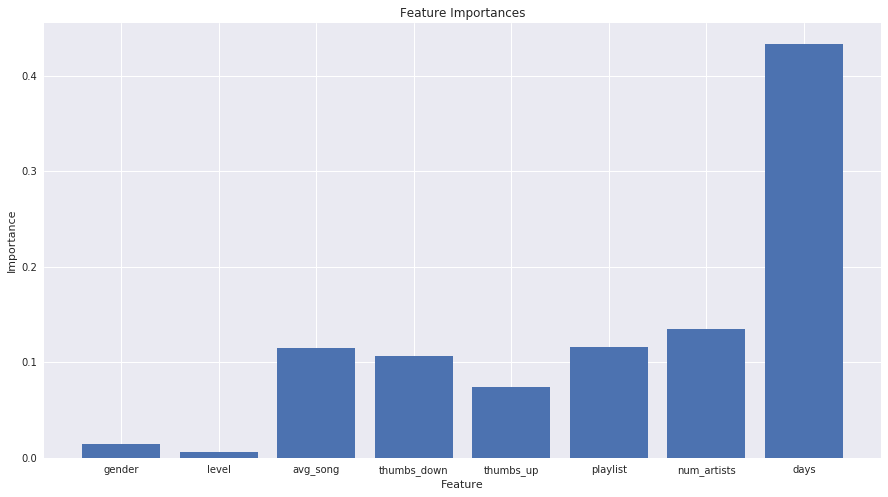

In [132]:
plt.figure(figsize=[15,8])
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

As we can see, the feature with highest importance is the number of days after registration in the app.

<a id='conclusion'></a>
# Conclusion
A small dataset of just 128MB and 225 unique customers was used. After loading and cleaning the data was explored for useful features to help predict churn and to build out the most promising features. Then the features were preprocessed and used with different machine learning algorithms. Random Forest performed the best, achieving an accuracy of 0.84 and F1 score of 0.76.

<a id='improvements'></a>
# Improvements
* Building more features from the dataset.
* Testing the data with other machine learning algorithms.

<a id='reference'></a>
# References
* https://stackoverflow.com/questions/52943627/convert-a-pandas-dataframe-to-a-pyspark-dataframe
* https://stackoverflow.com/questions/46956026/how-to-convert-column-with-string-type-to-int-form-in-pyspark-data-frame
* https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
* https://stackoverflow.com/questions/32565829/simple-way-to-measure-cell-execution-time-in-ipython-notebook
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html